# Equidistant classes and cost matrix

In this Notebook we test the performance of various models in a two dimensional dataset with three equidistant classes. The idea is to extend the dataset generator to incorporate a hierarchy on the class difficulty, and to evaluate models that consider a hierarchical cost that is not correlated to the intrinsic hierarchy of difficulty (e.g. a class should have more errors if it overlaps more with another class).

The tested 

The current data generator only generates Gaussian distributions in one dimension for two class problems, and two dimensions for three class problems.

# Dataset generator

In [8]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

random_state = 42


class EquidistantDataset(object):
    def __init__(self, n_classes=3, random_state=42):
        self.n_classes = n_classes
        self.random_state = random_state
        
    def _initialise(self):
        if not hasattr(self, 'has_been_initialised'):
            
            # TODO come up with general formula
            if self.n_classes == 2:
                self.centers = np.array([[-0.5], [0.5]])
                self.n_features = self.n_classes - 1
            elif self.n_classes == 3:
                self.centers = np.array([
                    [0, 0.5/np.cos(np.radians(30))],
                    [-0.5, -0.5*np.tan(np.radians(30))],
                    [+0.5, -0.5*np.tan(np.radians(30))]])
                np.random.seed(self.random_state)
                self.rotation_angle = np.random.rand(1)
                self.rotation = np.array([[np.cos(self.rotation_angle), -np.sin(self.rotation_angle)],
                                          [np.sin(self.rotation_angle),  np.cos(self.rotation_angle)]
                                         ])
                self.centers = np.inner(self.rotation.reshape(2, 2), self.centers).T
                self.n_features = self.n_classes - 1
            else:
                self.centers = np.eye(self.n_classes)[np.arange(self.n_classes)]
                self.n_features = self.n_classes
            self.cluster_std = 0.5
            self.sample_iteration = 0
            self.has_been_initialised = True
        
    def sample(self, n_samples):
        self._initialise()
        self.sample_iteration += 1
        return make_blobs(n_samples=n_samples, n_features=self.n_features,
                          centers=self.centers, cluster_std=self.cluster_std,
                          shuffle=True,
                          random_state=self.random_state + self.sample_iteration,
                          return_centers=False)

## Example of seven classes

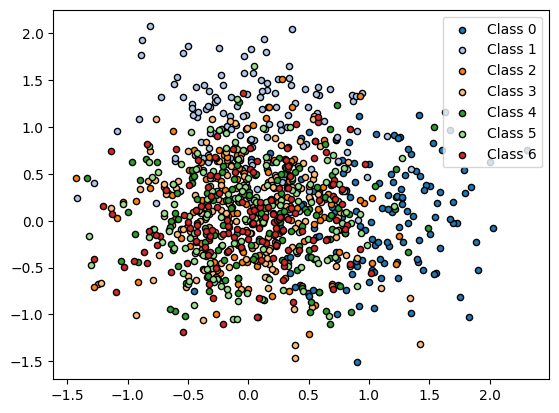

In [9]:
n_classes = 7

generator = EquidistantDataset(n_classes=n_classes)
X_train, y_train = generator.sample(1000)

colors = plt.get_cmap('tab20')

for i in range(generator.n_classes):
    color = colors.colors[i]
    idx = np.where(y_train == i)
    plt.scatter(
        X_train[idx, 0],
        X_train[idx, 1],
        c=[color,], #[color,]*sum(y_train == i),
        label='Class ' + str(i),
        #cmap=plt.cm.Paired,
        edgecolor="black",
        s=20,
    )
plt.legend()

In [32]:
centers = generator.centers

distance = np.zeros((centers.shape[0], centers.shape[0]))
for i in range(centers.shape[0]):
    for j in range(centers.shape[0]):
        distance[i,j] = np.sqrt(np.sum((centers[i] - centers[j])**2))

print(distance.round(2))

[[0.   1.41 1.41 1.41 1.41 1.41 1.41]
 [1.41 0.   1.41 1.41 1.41 1.41 1.41]
 [1.41 1.41 0.   1.41 1.41 1.41 1.41]
 [1.41 1.41 1.41 0.   1.41 1.41 1.41]
 [1.41 1.41 1.41 1.41 0.   1.41 1.41]
 [1.41 1.41 1.41 1.41 1.41 0.   1.41]
 [1.41 1.41 1.41 1.41 1.41 1.41 0.  ]]


# Decision tree

Now we test the performance of a scikit-learn decision tree on the generated dataset.

In [33]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

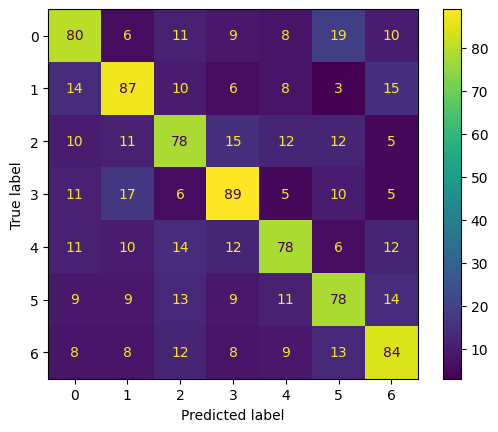

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test, y_test = generator.sample(1000)
predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

## Multiple repetitions

The dataset generator has some random components, here we repeat the generation multiple times and aggregate the performance of each decision tree.

In [35]:
n_repetitions = 100
n_samples = 1000

cm_list = []
for r in range(n_repetitions):
    generator = EquidistantDataset(n_classes=generator.n_classes, random_state=100+r)
    X_train, y_train = generator.sample(n_samples)
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    X_test, y_test = generator.sample(n_samples)
    predictions = clf.predict(X_test)

    cm_list.append(confusion_matrix(y_test, predictions))

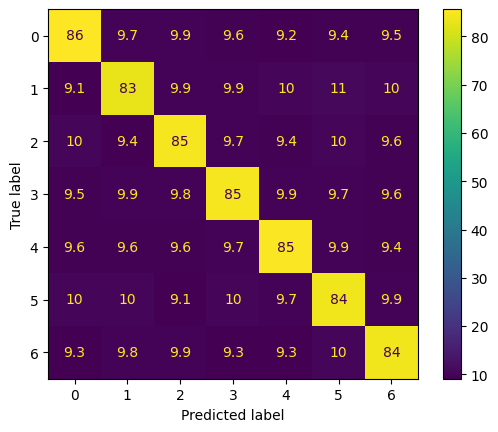

In [36]:
disp = ConfusionMatrixDisplay(np.mean(cm_list, axis=0))
disp.plot()

# Hierarchical loss

In [40]:
from himpurity._criterion import CustomGini
from himpurity.classes import ClassHierarchy
from himpurity.criterion import (MHICriterion,
                                 ClassifierCriterionBinder,
                                 DecisionTreeBinder,
                                 RandomForestBinder,
                                 valid_criterion)
from himpurity.estimators import MultilabelHimpurity, multilabel_himpurity

# from DecisionTree.DecisionTree import DecisionTreeClassifier as DT
# from DecisionTree.classes import EstimatorWrapper

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from himpurity.tests.utils import make_digits_dataset, train_test_predict

ROOT = "R"
hierarchy_dict = {
    "R": ["A", "B"],
    "A": [1, 2],
    "B": ["C", "D"],
    "C": [3, 4],
    "D": [5, "E"],
    "E": [6, 7]
}
ch_hierarchy = ClassHierarchy(hierarchy_dict, root=ROOT)
global_params = {"max_depth": 3, "random_state": random_state}

clf_dict = {}

model_name = "DT_MHI_binded"

clf_dict[model_name] = ClassifierCriterionBinder(DecisionTreeClassifier,
                                                      MHICriterion,
                                                      ch_hierarchy,
                                                      clf_params=global_params)

clf_dict[model_name].fit(X_train, y_train)

DecisionTreeClassifier(criterion=<himpurity.criterion.MHICriterion object at 0x9b712b0>,
                       max_depth=3, random_state=42)

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test, y_test = generator.sample(1000)
predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

TypeError: predict() missing 1 required positional argument: 'X'

# PyTorch Multinomial Logistic Regression

We will use in the following experiments a Multinomial Logistic Regression implemented with PyTorch and using skorch to use the model as a scikit-learn probabilistic classifier.

In [39]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping


class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, generator.n_classes)
        
    def forward(self, x):
        x = F.softmax(self.layer1(x), dim=1)
        return x

    from skorch import NeuralNetBinaryClassifier, NeuralNetClassifier

model = NeuralNetClassifier(
    Model(input_dim=generator.n_features),
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.0001,
    max_epochs=500,
    batch_size=10,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 50,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)

print(model)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=Model(
    (layer1): Linear(in_features=7, out_features=7, bias=True)
  ),
)


## Numpy arrays to tensors

PyTorch models require PyTorch tensors in order to train. Here we convert every numpy array into a PyTorch tensor.

In [16]:
X_train_tensor = Variable(torch.from_numpy(X_train)).float()
y_train_tensor = Variable(torch.from_numpy(y_train)).long()
X_test_tensor  = Variable(torch.from_numpy(X_test)).float()
y_test_tensor  = Variable(torch.from_numpy(y_test)).long()

In [17]:
model.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9425       0.1850        1.9457  0.0887
      2        1.9414       0.1850        1.9447  0.0597
      3        1.9402       0.1800        1.9436  0.0587
      4        1.9391       0.1900        1.9426  0.0583
      5        1.9379       0.1900        1.9416  0.0578
      6        1.9368       0.1950        1.9405  0.0523
      7        1.9356       0.2000        1.9395  0.0589
      8        1.9344       0.2050        1.9384  0.0540
      9        1.9333       0.2150        1.9373  0.0534
     10        1.9321       0.2250        1.9363  0.0530
     11        1.9309       0.2250        1.9352  0.0521
     12        1.9297       0.2250        1.9341  0.0524
     13        1.9285       0.2400        1.9330  0.0529
     14        1.9273       0.2350        1.9319  0.0522
     15        1.9261       0.2350        1.9308  0.0525
     16        1.9248       0.2

    103        1.8097       0.5150        1.8232  0.0580
    104        1.8083       0.5200        1.8219  0.0601
    105        1.8070       0.5200        1.8207  0.0601
    106        1.8057       0.5250        1.8195  0.0600
    107        1.8044       0.5300        1.8183  0.0601
    108        1.8030       0.5350        1.8170  0.0555
    109        1.8017       0.5350        1.8158  0.0599
    110        1.8004       0.5400        1.8146  0.0601
    111        1.7991       0.5450        1.8134  0.0601
    112        1.7978       0.5450        1.8122  0.0601
    113        1.7964       0.5450        1.8110  0.0602
    114        1.7951       0.5450        1.8098  0.0604
    115        1.7938       0.5450        1.8086  0.0602
    116        1.7925       0.5450        1.8074  0.0605
    117        1.7912       0.5450        1.8062  0.0601
    118        1.7899       0.5450        1.8050  0.0603
    119        1.7886       0.5500        1.8038  0.0555
    120        1.7873       0.5

    210        1.6824       0.6700        1.7085  0.0588
    211        1.6814       0.6750        1.7077  0.0537
    212        1.6804       0.6750        1.7068  0.0531
    213        1.6794       0.6750        1.7059  0.0532
    214        1.6785       0.6750        1.7051  0.0531
    215        1.6775       0.6750        1.7042  0.0532
    216        1.6765       0.6750        1.7034  0.0531
    217        1.6756       0.6800        1.7025  0.0532
    218        1.6746       0.6800        1.7017  0.0537
    219        1.6737       0.6800        1.7008  0.0542
    220        1.6727       0.6800        1.7000  0.0530
    221        1.6718       0.6800        1.6992  0.0527
    222        1.6708       0.6800        1.6983  0.0528
    223        1.6699       0.6750        1.6975  0.0525
    224        1.6690       0.6750        1.6967  0.0528
    225        1.6680       0.6750        1.6959  0.0530
    226        1.6671       0.6750        1.6951  0.0526
    227        1.6662       0.6

    319        1.5987       0.6850        1.6353  0.0552
    320        1.5981       0.6850        1.6348  0.0550
    321        1.5976       0.6850        1.6343  0.0549
    322        1.5970       0.6850        1.6338  0.0550
    323        1.5964       0.6850        1.6333  0.0551
    324        1.5959       0.6850        1.6328  0.0551
    325        1.5953       0.6850        1.6323  0.0550
    326        1.5948       0.6850        1.6319  0.0550
    327        1.5942       0.6850        1.6314  0.0548
    328        1.5937       0.6850        1.6309  0.0554
    329        1.5931       0.6850        1.6304  0.0579
    330        1.5926       0.6850        1.6300  0.0554
    331        1.5920       0.6850        1.6295  0.0550
    332        1.5915       0.6850        1.6290  0.0552
    333        1.5910       0.6850        1.6286  0.0583
    334        1.5904       0.6850        1.6281  0.0552
    335        1.5899       0.6850        1.6277  0.0549
    336        1.5894       0.6

    429        1.5501       0.6750        1.5940  0.0555
    430        1.5497       0.6750        1.5937  0.0553
    431        1.5494       0.6750        1.5934  0.0586
    432        1.5491       0.6750        1.5931  0.0551
    433        1.5487       0.6750        1.5928  0.0550
    434        1.5484       0.6750        1.5926  0.0550
    435        1.5481       0.6750        1.5923  0.0550
    436        1.5478       0.6750        1.5920  0.0590
    437        1.5474       0.6750        1.5918  0.0551
    438        1.5471       0.6750        1.5915  0.0550
    439        1.5468       0.6750        1.5912  0.0550
    440        1.5465       0.6750        1.5910  0.0551
    441        1.5461       0.6750        1.5907  0.0557
    442        1.5458       0.6750        1.5904  0.0551
    443        1.5455       0.6750        1.5902  0.0552
    444        1.5452       0.6750        1.5899  0.0550
    445        1.5449       0.6750        1.5896  0.0550
    446        1.5446       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=7, out_features=7, bias=True)
  ),
)

In [18]:
from sklearn.inspection import DecisionBoundaryDisplay


def plot_decision_boundary_pytorch(X, y, model):
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max()),
        np.linspace(X[:, 1].min(), X[:, 1].max())
    )

    feature_1 = Variable(torch.from_numpy(feature_1)).float()
    feature_2 = Variable(torch.from_numpy(feature_2)).float()
    grid = Variable(torch.from_numpy(np.vstack([feature_1.ravel(), feature_2.ravel()]).T)).float()

    y_pred = np.reshape(model.predict(grid), feature_1.shape)
    display = DecisionBoundaryDisplay(
        xx0=feature_1, xx1=feature_2, response=y_pred
    )
    display.plot()
    plt.axis("tight")

    colors = ['blue', 'green', 'yellow']

    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label='Class ' + str(i),
            edgecolor="black",
            s=20,
        )
    plt.legend()
    
#plot_decision_boundary_pytorch(X_test, y_test, model)

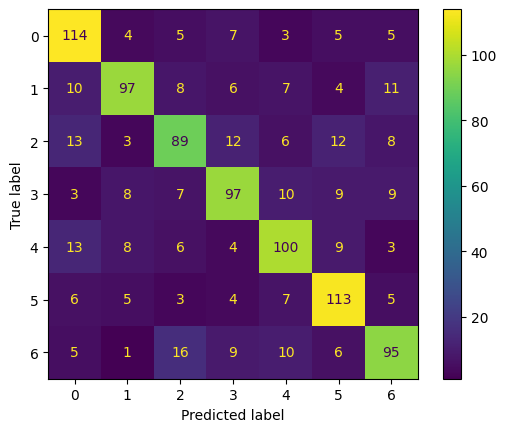

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Train a neural network with specified loss

## True class absolute loss

The following is an example defining an absolute loss, only for the true positive label

$$
\Psi (\mathbf{y}, \mathbf{q}) = 1 - \sum_{i=1}^K y_i*q_i  \qquad \in [0, 1]
$$

which for a perfect prediction for $y_i = 1$ and $q_i = 1$ has the smallest loss $\Psi (\mathbf{y}, \mathbf{q}) = 0$.

In [20]:
class TrueClassAbsoluteLoss(nn.Module):
    def __init__(self):
        super(TrueClassAbsoluteLoss, self).__init__()
    
    def forward(self, output, target):
        target = torch.LongTensor(target)
        target = nn.functional.one_hot(target, num_classes=generator.n_classes).float()
        loss = torch.einsum('ij,ij->i', target, output)
        #print(target)
        #print(output)
        #print(loss)
        loss = 1 - loss.mean()
        return loss


model = NeuralNetClassifier(
    Model(input_dim=generator.n_features),
    criterion=TrueClassAbsoluteLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=500,
    batch_size=10,
    verbose=1,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 10,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)

X_train_tensor = Variable(torch.from_numpy(X_train)).float()
y_train_tensor = Variable(torch.from_numpy(y_train)).long()
X_test_tensor  = Variable(torch.from_numpy(X_test)).float()
y_test_tensor  = Variable(torch.from_numpy(y_test)).long()

model.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8623       0.1400        0.8557  0.0665
      2        0.8510       0.2000        0.8447  0.0656
      3        0.8388       0.2700        0.8327  0.0728
      4        0.8256       0.3000        0.8199  0.0726
      5        0.8114       0.3650        0.8062  0.0658
      6        0.7965       0.4100        0.7918  0.0708
      7        0.7808       0.4800        0.7769  0.0708
      8        0.7646       0.5350        0.7616  0.0693
      9        0.7480       0.5600        0.7461  0.0699
     10        0.7313       0.5900        0.7307  0.0702
     11        0.7146       0.5950        0.7154  0.0709
     12        0.6981       0.6050        0.7004  0.0686
     13        0.6820       0.6150        0.6858  0.0711
     14        0.6662       0.6200        0.6718  0.0711
     15        0.6510       0.6400        0.6583  0.0708
     16        0.6363       0.6

    107        0.3270       0.6700        0.3884  0.0679
    108        0.3263       0.6700        0.3879  0.0640
    109        0.3256       0.6700        0.3874  0.0646
    110        0.3250       0.6700        0.3869  0.0638
    111        0.3243       0.6700        0.3864  0.0636
    112        0.3237       0.6700        0.3860  0.0638
    113        0.3230       0.6700        0.3855  0.0643
    114        0.3224       0.6700        0.3851  0.0641
    115        0.3218       0.6700        0.3846  0.0666
    116        0.3212       0.6650        0.3842  0.0642
    117        0.3206       0.6650        0.3838  0.0639
    118        0.3200       0.6650        0.3833  0.0641
    119        0.3194       0.6650        0.3829  0.0719
    120        0.3188       0.6650        0.3825  0.0641
    121        0.3183       0.6650        0.3821  0.0643
    122        0.3177       0.6650        0.3817  0.0648
    123        0.3172       0.6650        0.3814  0.0642
    124        0.3166       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=7, out_features=7, bias=True)
  ),
)

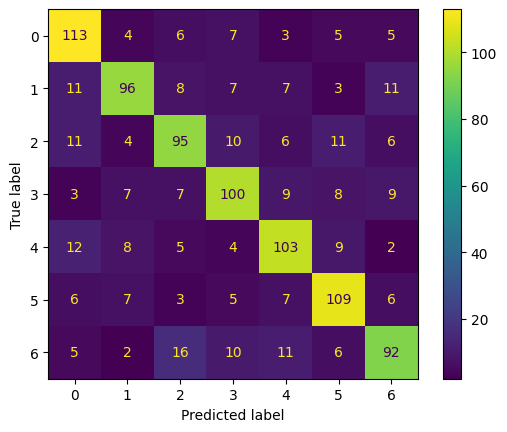

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [22]:
#plot_decision_boundary_pytorch(X_test, y_test, model)

## Cross entropy


The following is an example defining cross entropy, only for the true positive label

$$
\Psi (\mathbf{y}, \mathbf{q}) = - \sum_{i=1}^K y_i*q_i \qquad \in [0, \infty)
$$

which for a perfect prediction for $y_i = 1$ and $q_i = 1$ has the smallest loss $\Psi (\mathbf{y}, \mathbf{q}) = 0$.

In [22]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
    
    def forward(self, output, target):
        target = torch.LongTensor(target)
        target = nn.functional.one_hot(target, num_classes=generator.n_classes).float()
        loss = -torch.einsum('ij,ij->i', target, torch.log(output))
        #print(target)
        #print(output)
        #print(loss)
        loss = loss.mean()
        return loss

model = NeuralNetClassifier(
    Model(input_dim=generator.n_features),
    #criterion=torch.nn.BCEWithLogitsLoss,
    criterion=CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=500,
    batch_size=10,
    verbose=1,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 10,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)

X_train_tensor = Variable(torch.from_numpy(X_train)).float()
y_train_tensor = Variable(torch.from_numpy(y_train)).long()
X_test_tensor  = Variable(torch.from_numpy(X_test)).float()
y_test_tensor  = Variable(torch.from_numpy(y_test)).long()

model.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0087       0.1900        1.9736  0.0703
      2        1.9292       0.2250        1.9020  0.0679
      3        1.8550       0.2700        1.8348  0.0725
      4        1.7852       0.3200        1.7719  0.0704
      5        1.7196       0.3950        1.7129  0.0702
      6        1.6580       0.4500        1.6578  0.0702
      7        1.6002       0.5000        1.6064  0.0710
      8        1.5461       0.5350        1.5584  0.0667
      9        1.4956       0.5650        1.5138  0.0667
     10        1.4483       0.5850        1.4723  0.0669
     11        1.4042       0.6150        1.4338  0.0672
     12        1.3630       0.6350        1.3980  0.0668
     13        1.3247       0.6550        1.3648  0.0666
     14        1.2889       0.6550        1.3341  0.0666
     15        1.2556       0.6500        1.3055  0.0664
     16        1.2245       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=7, out_features=7, bias=True)
  ),
)

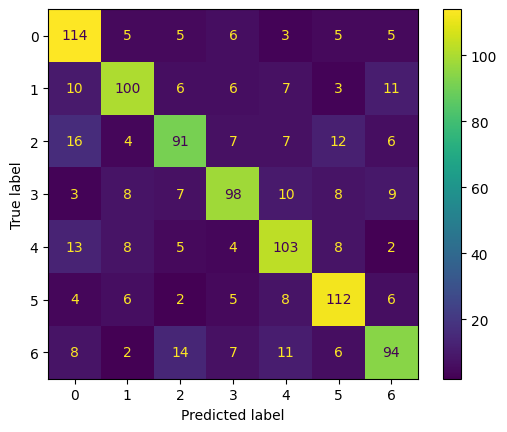

In [23]:
predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [24]:
#plot_decision_boundary_pytorch(X_test, y_test, model)

# Loss based on a cost matrix

Having a true label in a one-hot-encoding vector

$$
\mathbf{y} = [y_1, y_2, \dots, y_K]
$$

a cost matrix where each row is a true class and every column is the predicted class

$$
\mathbf{C} = \begin{bmatrix}
c_{1,1} & c_{1,2} & \dots  & c_{1,K} \\
c_{2,1} & c_{2,2} & \dots  & c_{2,K} \\
\vdots  & \vdots  & \ddots & \vdots \\
c_{K,1} & c_{K,2} & \dots  & c_{K,K} \\
\end{bmatrix}
$$

and the scores of a classifier

$$
\mathbf{s} = [s_1, s_2, \dots, s_K]
$$

We can compute the cost of predicting with a score $\mathbf{s}$ a true label $\mathbf{y}$ as

$$
\mathbf{y} \mathbf{C} \mathbf{s}^\intercal =
[y_1, y_2, \dots, y_K]
\begin{bmatrix}
c_{1,1} & c_{1,2} & \dots  & c_{1,K} \\
c_{2,1} & c_{2,2} & \dots  & c_{2,K} \\
\vdots  & \vdots  & \ddots & \vdots \\
c_{K,1} & c_{K,2} & \dots  & c_{K,K} \\
\end{bmatrix}
\begin{bmatrix}
s_1 \\ s_2 \\ \dots \\ s_K
\end{bmatrix}
$$

where, the true label $\mathbf{y}$ selects what row of the cost matrix $\mathbf{C}$ is being used as weights. The following is an example with an instantiated true label

$$
[0, 1, \dots, 0]
\begin{bmatrix}
c_{0,0} & c_{0,1} & \dots  & c_{0,K} \\
c_{1,0} & c_{1,1} & \dots  & c_{1,K} \\
\vdots  & \vdots  & \ddots & \vdots \\
c_{K,0} & c_{K,1} & \dots  & c_{K,K} \\
\end{bmatrix}
\begin{bmatrix}
s_1 \\ s_2 \\ \dots \\ s_K
\end{bmatrix}
=
[c_{1,0}, c_{1,1}, \dots, c_{1,K}]
\begin{bmatrix}
s_1 \\ s_2 \\ \dots \\ s_K
\end{bmatrix}
=
\sum_{i=1}^K c_{1,i}s_i
$$

In [25]:
C = np.ones(shape=(n_classes, n_classes)) - np.eye(n_classes)

print(C)
 
class MatrixCostLoss(nn.Module):
    def __init__(self, C):
        super(MatrixCostLoss, self).__init__()
        self.C = Variable(torch.from_numpy(C)).float()

    
    def forward(self, output, target):
        target = torch.LongTensor(target)
        target = nn.functional.one_hot(target, num_classes=n_classes).float()
        loss = torch.einsum('ij,jk->ik', target, self.C)
        #print(target)
        #print(M)
        #print(loss)
        loss = torch.einsum('ij,ij->i', loss, output)
        #print(output)
        #print(loss)
        loss = loss.mean()
        return loss


model = NeuralNetClassifier(
    Model(input_dim=n_classes),
    #criterion=torch.nn.BCEWithLogitsLoss,
    criterion=MatrixCostLoss(C),
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=500,
    batch_size=10,
    verbose=1,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 10,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)

X_train_tensor = Variable(torch.from_numpy(X_train)).float()
y_train_tensor = Variable(torch.from_numpy(y_train)).long()
X_test_tensor  = Variable(torch.from_numpy(X_test)).float()
y_test_tensor  = Variable(torch.from_numpy(y_test)).long()

model.fit(X_train_tensor, y_train_tensor)

[[0. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 0.]]
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8423       0.2350        0.8396  0.0659
      2        0.8298       0.3100        0.8277  0.0659
      3        0.8165       0.3750        0.8151  0.0661
      4        0.8025       0.4550        0.8017  0.0671
      5        0.7877       0.5000        0.7876  0.0662
      6        0.7723       0.5450        0.7730  0.0689
      7        0.7565       0.5650        0.7581  0.0675
      8        0.7404       0.5700        0.7429  0.0661
      9        0.7243       0.5850        0.7276  0.0714
     10        0.7082       0.6000        0.7125  0.0680
     11        0.6924       0.6150        0.6977  0.0651
     12        0.6769       0.6200        0.6833  0.0652
     13        0.6618       0.630

    105        0.3276       0.6650        0.3899  0.0679
    106        0.3269       0.6650        0.3894  0.0683
    107        0.3262       0.6650        0.3889  0.0679
    108        0.3255       0.6650        0.3883  0.0680
    109        0.3248       0.6650        0.3879  0.0682
    110        0.3241       0.6650        0.3874  0.0675
    111        0.3235       0.6650        0.3869  0.0673
    112        0.3229       0.6650        0.3864  0.0737
    113        0.3222       0.6650        0.3860  0.0676
    114        0.3216       0.6650        0.3855  0.0677
    115        0.3210       0.6650        0.3851  0.0680
    116        0.3204       0.6650        0.3846  0.0731
    117        0.3198       0.6650        0.3842  0.0677
    118        0.3192       0.6650        0.3838  0.0682
    119        0.3187       0.6650        0.3834  0.0691
    120        0.3181       0.6650        0.3830  0.0717
    121        0.3175       0.6650        0.3826  0.0681
    122        0.3170       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=7, out_features=7, bias=True)
  ),
)

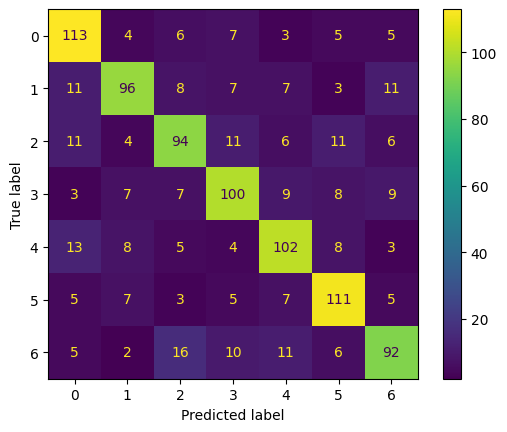

In [26]:
predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [27]:
#plot_decision_boundary_pytorch(X_test, y_test, model)

## Non-uniform Cost Matrix


We can increase the cost of predicting \textbf{class 1} when the true class is \textbf{class 2}, thus expecting less errors on the corresponding confusion matrix cell.

In [28]:
C = np.arange(1, n_classes+1).repeat(n_classes).reshape(n_classes, n_classes).T * (1 - np.eye(n_classes))
print(C)

model = NeuralNetClassifier(
    Model(input_dim=generator.n_features),
    #criterion=torch.nn.BCEWithLogitsLoss,
    criterion=MatrixCostLoss(C),
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=500,
    batch_size=10,
    verbose=1,
    callbacks=[('estoper', EarlyStopping(monitor='valid_loss',
                                         patience = 50,
                                         threshold = 0.01,
                                         threshold_mode='rel',
                                         lower_is_better=True))]
)


model.fit(X_train_tensor, y_train_tensor)

[[0. 2. 3. 4. 5. 6. 7.]
 [1. 0. 3. 4. 5. 6. 7.]
 [1. 2. 0. 4. 5. 6. 7.]
 [1. 2. 3. 0. 5. 6. 7.]
 [1. 2. 3. 4. 0. 6. 7.]
 [1. 2. 3. 4. 5. 0. 7.]
 [1. 2. 3. 4. 5. 6. 0.]]
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.3820       0.1500        3.2825  0.0687
      2        3.1881       0.1500        3.1028  0.0683
      3        3.0007       0.1800        2.9303  0.0739
      4        2.8222       0.1900        2.7666  0.0734
      5        2.6548       0.1950        2.6128  0.0734
      6        2.4998       0.1900        2.4698  0.0701
      7        2.3580       0.1800        2.3380  0.0721
      8        2.2295       0.1950        2.2175  0.0647
      9        2.1136       0.2100        2.1080  0.0647
     10        2.0093       0.2000        2.0091  0.0650
     11        1.9158       0.2050        1.9198  0.0648
     12        1.8317       0.2000        1.8395  0.0650
     13        1.7562       0.205

    105        0.7912       0.2800        0.8176  0.0661
    106        0.7902       0.2800        0.8167  0.0666
    107        0.7892       0.2800        0.8159  0.0664
    108        0.7882       0.2800        0.8152  0.0679
    109        0.7872       0.2800        0.8144  0.0664
    110        0.7863       0.2800        0.8137  0.0664
    111        0.7854       0.2800        0.8130  0.0663
    112        0.7845       0.2800        0.8123  0.0663
    113        0.7836       0.2800        0.8116  0.0667
    114        0.7828       0.2800        0.8110  0.0665
    115        0.7820       0.2800        0.8104  0.0671
    116        0.7812       0.2800        0.8098  0.0685
    117        0.7804       0.2850        0.8092  0.0671
    118        0.7796       0.2850        0.8086  0.0669
    119        0.7788       0.2850        0.8081  0.0668
    120        0.7781       0.2850        0.8076  0.0689
    121        0.7774       0.2850        0.8070  0.0669
    122        0.7767       0.2

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (layer1): Linear(in_features=7, out_features=7, bias=True)
  ),
)

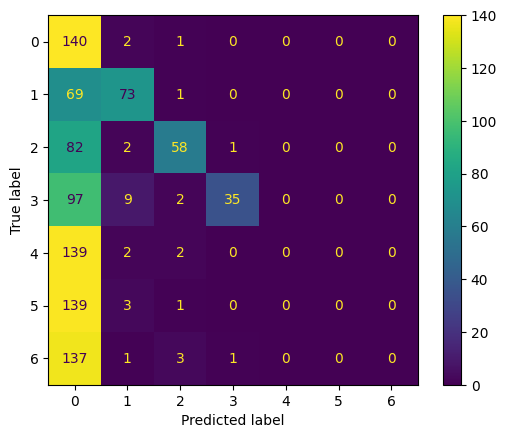

In [29]:
predictions = model.predict(X_test_tensor)

cm = confusion_matrix(y_test_tensor, predictions)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [30]:
#plot_decision_boundary_pytorch(X_test, y_test, model)